### Markov Chain Monte Carlo and Bayesian Inference

#### Problem Description

My Garmin Vivosmart watch tracks the time I fall asleep and wake up each day using motion sensing and heart rate monitoring. To augment this data, I have estimated likelihoods that I am asleep based on the condition of my bedroom light (on/off) and if my phone is charging (yes/no). My objective is to use this data to create a model that returns the probability I am asleep at a specific time for a given status of my bedroom light and phone. For a specific time, the probability of sleep given information about my bedroom light and phone is expressed as:

_P(sleepbedroom light, phone charging)_

In probability theory terms, this is the posterior probability at a specific time I am asleep given the status of my bedroom light and condition of my phone. The time is a continuous variable and the two additional pieces of information are discrete variables each with two states.

### Approach

In order to solve this problem, I first need to express the final model in terms of Bayes Rule

The general method is as follows, with additional details provided in the respective sections.

1. Format the data (done in separate notebook) and visualize
2. Choose function to represent probabilty of sleep given the time
3. Use Markov Chain Monte Carlo and the data to find most likely parameters for the selected posterior distribution
4. Use the posterior probability as the prior for applying Bayes Rule using additional data about light and phone status
4. Build a model for Bayesian Inference to find the probabilty of sleep given the time, light condition, and phone charging info
Interpret and visualize model
5. We can do this separately for both the sleep and waking data, although I will only build the complete model for the sleep data.

I make extensive use of the PyMC3 library for Markov Chain Monte Carlo and Bayesian Inference methods.

#### Data Exploration 

The wake and sleep data contains more than two months of information. The watch records when I fall asleep and wake up based on motion and heart rate. It is not 100% accurate as it often will think I'm sleeping if I turn off notifications and am quietly reading in bed. Sometimes we have to deal with imperfect data, and, because there are more truthful than false observations, we can expect the correct data to have a larger effect on the model.

First, we will import the required libraries, and visualize both the sleep data and the waking data.

In [1]:
# pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# scipy for algorithms
import scipy
from scipy import stats

# pymc3 for Bayesian Inference, pymc built on t
import pymc3 as pm
import theano.tensor as tt
import scipy

# matplotlib for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize
import matplotlib

import json
s = json.load(open('bmh_matplotlibrc.json'))
#matplotlib.rcParams.update(s)
matplotlib.rcParams['figure.figsize'] = (10, 3)
matplotlib.rcParams['font.size'] = 14

# Number of samples for Markov Chain Monte Carlo
N_SAMPLES = 1000

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\Daniela\Anaconda3.5\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# Data formatted in different notebook
sleep_data = pd.read_csv('sleep_data.csv')
wake_data = pd.read_csv('wake_data.csv')

# Labels for plotting
sleep_labels = ['9:00', '9:30', '10:00', '10:30', '11:00', '11:30', '12:00']
wake_labels = ['5:00', '5:30', '6:00', '6:30', '7:00', '7:30', '8:00']

In [3]:
#sleep data


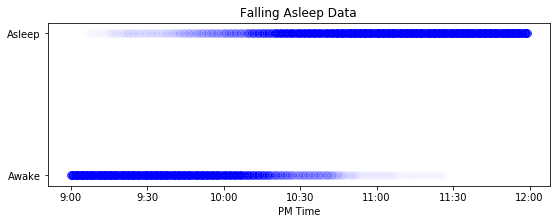

In [4]:
figsize(9, 3)

# Sleep data
plt.scatter(sleep_data['time_offset'], sleep_data['indicator'], 
            s= 60, alpha=0.01, facecolor = 'b', edgecolors='b')
plt.yticks([0, 1], ['Awake', 'Asleep']); plt.xlabel('PM Time'); 
plt.title('Falling Asleep Data')
plt.xticks([-60, -30, 0, 30, 60, 90, 120], sleep_labels);

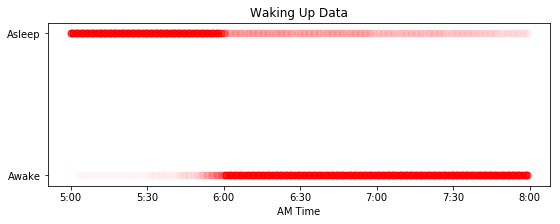

In [5]:
#awake data
# Wake data
plt.scatter(wake_data['time_offset'], wake_data['indicator'], 
            s= 50, alpha = 0.01, facecolor='r', edgecolors =  'r');
plt.yticks([0, 1], ['Awake', 'Asleep']); plt.xlabel('AM Time');
plt.title('Waking Up Data')
plt.xticks([-60, -30, 0, 30, 60, 90, 120], wake_labels);

#### Logistic Function to Represent Transition

We need to decide on a function to represent the transition from being awake to sleeping. There are a number of acceptable models, and here we will assume this transition can be modeled as a logistic function. A logistic function (also called a sigmoid) is a non-linear function bounded between 0 and 1.

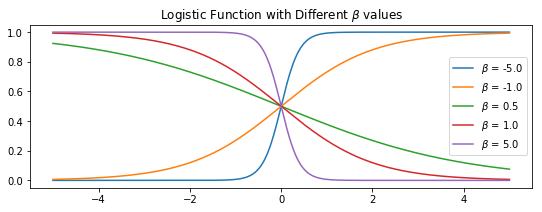

In [6]:
figsize(9,3)
# logistic function with beta
def logistic(x,beta):
    return 1./(1.+np.exp(beta*x))

x=np.linspace(-5,5, 1000)
for beta in [-5, -1, 0.5, 1, 5]:
    plt.plot(x, logistic(x, beta), label=r"$\beta$ = %.1f" %beta)
plt.legend();
plt.title(r'Logistic Function with Different $\beta$ values');

There is one problem with the basic logistic function as shown above: the transition is centered at 0. However, in my sleeping data, the transition is around 10:00 pm for sleeping and 6:00 am for waking. 

We address this by adding an offset, called a bias, to adjust the location of the logistic function.
This introduces another unknown parameter, $\alpha$, which we will also find from Markov Chain Monte Carlo.

The logistic function with various $\alpha$ and $\beta$ parameters is shown below.

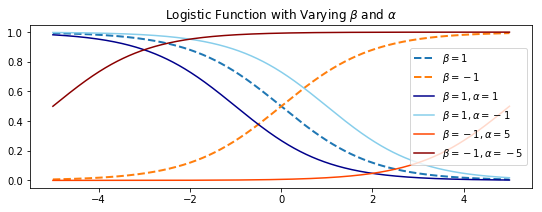

In [7]:
#logistic function with beta and alpha
def logistic(x, beta, alpha=0):
    return 1.0/(1.0+np.exp(np.dot(beta,x)+alpha))
x = np.linspace(-5, 5, 1000)

plt.plot(x, logistic(x, beta=1), label=r"$\beta = 1$", ls="--", lw=2)
plt.plot(x, logistic(x, beta=-1), label=r"$\beta = -1$", ls="--", lw=2)

plt.plot(x, logistic(x, 1, 1), 
         label=r"$\beta = 1, \alpha = 1$", color="darkblue")
plt.plot(x, logistic(x, 1, -1),
         label=r"$\beta = 1, \alpha = -1$",color="skyblue")
plt.plot(x, logistic(x, -1, 5), 
         label=r"$\beta = -1, \alpha = 5$", color="orangered")
plt.plot(x, logistic(x, -1, -5), 
         label=r"$\beta = -1, \alpha = -5$", color="darkred")
plt.legend();
plt.title(r'Logistic Function with Varying $\beta$ and $\alpha$');

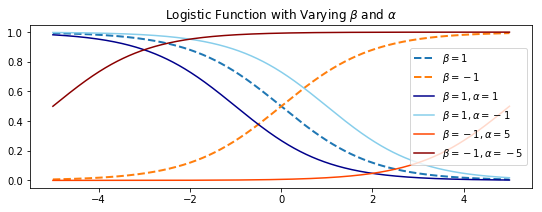

In [8]:
# Logistic function with both beta and alpha
def logistic(x, beta, alpha=0):
    return 1.0 / (1.0 + np.exp(np.dot(beta, x) + alpha))

x = np.linspace(-5, 5, 1000)

plt.plot(x, logistic(x, beta=1), label=r"$\beta = 1$", ls="--", lw=2)
plt.plot(x, logistic(x, beta=-1), label=r"$\beta = -1$", ls="--", lw=2)

plt.plot(x, logistic(x, 1, 1), 
         label=r"$\beta = 1, \alpha = 1$", color="darkblue")
plt.plot(x, logistic(x, 1, -1),
         label=r"$\beta = 1, \alpha = -1$",color="skyblue")
plt.plot(x, logistic(x, -1, 5), 
         label=r"$\beta = -1, \alpha = 5$", color="orangered")
plt.plot(x, logistic(x, -1, -5), 
         label=r"$\beta = -1, \alpha = -5$", color="darkred")
plt.legend();
plt.title(r'Logistic Function with Varying $\beta$ and $\alpha$');


$\beta$ shifts the direction and steepness of the curve, while $\alpha$ changes the location. We will use MCMC to find the most likely value of these parameters under the data.

#### Prior Distribution for $\beta$ and $\alpha$

We have no evidence to suggest what the prior distributions for the model parameters $\beta$ and $\alpha$ are ahead of time. Therefore, we can model them as if they came from a normal distribution. The normal, or Gaussian, distribution is defined by the mean, $\mu$, and the precision, $\tau$. The precision is the reciprocal of the standard deviation, $\sigma$. The mean defines the location of the distribution and the precision shows the spread. A larger value of $\tau$ indicates the data is less spread out (it is more precise) and hence the variation is smaller. 

Probability density functions for three normal distributions are shown below.

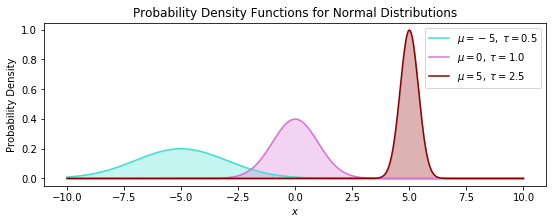

In [9]:
# Set up the plotting
normal=stats.norm
x=np.linspace(-10,10,1000)
mu=(-5,0,5)
tau=(0.5,1,2.5)
colors=("turquoise", "orchid", "darkred")

#plot pdfs
params=zip(mu,tau, colors)
for param in params:
    y=normal.pdf(x, loc=param[0], scale=1/param[1])
    plt.plot(x, y, 
             label="$\mu = %d,\;\\tau = %.1f$" % (param[0], param[1]), 
             color = param[2])
    plt.fill_between(x, y, color = param[2], alpha = 0.3)
plt.legend();
plt.xlabel("$x$")
plt.ylabel("Probability Density")
plt.title("Probability Density Functions for Normal Distributions");

The expected value of a normal distribution is the mean.

Again, we have no assumptions about the value for either $\mu$ or $\tau$ in the prior distributions for $\alpha$ and $\beta$. When we initialize the model, we can use $\mu = 0$ and a relatively large variance such as $\tau = 0.05$. Markov Chain Monte Carlo will samples values of $\mu$ and $\tau$ that try to maximize the likelihood of $\alpha$ and $\beta$ under the data.

### Markov Chain Monte Carlo

Markov Chain Monte Carlo will sample both $\beta$ and $\alpha$ from two normal distributions to find the parameters. Each iteration (state), an estimate for both $\beta$ and $\alpha$ are drawn from the prior. If the parameters increase the probabilty of the data, the state is accepted, but if the parameters are not in agreement with the data, the state is rejected. Monte Carlo refers to the sampling part of the algorithm. Markov Chain means that the next state is only dependent on the current state in a first order process (second order depends on the current and 1 previous step, third order on the current and 2 previous steps and so on). MCMC will return every sample of the parameters for the number of specified steps. This is known as the model trace. To find the most likely parameters, we can take the average of the samples in the trace. MCMC does not given an exact answer, but rather tries to find the maximum likelihood states under the data.

When modeling with MCMC up to 50% of the initial steps, referred to as the burn-in part of the trace, are discarded because the algorithm returns more likely parameters as the number of samples increases. The initial samples are less likely than the latter samples on average. There are a number of methods to test for convergence of MCMC, including visually inspecting the trace, and calculating the auto-correlation of the trace (a lower auto-correlation is an indicator of convergence). We will look at the trace in this example, but will not take rigorous steps to address convergence. There are also a number of methods to choose a smart starting value for the Markov Chain such as Maximum A Posterior estimation. Choosing an intelligent initial value can speed up convergence.

#### Posterior Probability of Sleep given Time

We have all the pieces for the poesterior probabilty and can now put them together. The logistic function describes the transition from awake to asleep, but we do not konw the parameters $\beta$ and $\alpha$. The aim is to find the parameters of the logistic function which maximize the likelihood of the observed data. The parameters are assumed to come from a normal distribution defined by a mean, $\mu$ and a variance, $\tau$. The MCMC algorithm will sample values of $\mu$ and $\tau$ for both $\alpha$ and $\beta$ to try and maximize the parameters of the logistic function given the data.

The data is connected to the parameters through a Bernoulli Variable.

#### Bernoulli Variable

A bernoulli variable is a discrete random variable that is either 0 or 1. In our example, we can model asleep or awake as a Bernoulli variable where awake is 0 and asleep is 1. The Bernoulli variable for sleep depends on the time, in a manner defined by the logistic function.

#### PyMC3 Model
We are using a powerful Bayesian Inference library in Python called PyMC3. This library has features for running Markov Chain Monte Carlo and other inference algorithms.

The following code creates the model and performs MCMC, drawing N_SAMPLES number of samples for $\beta$ and $\alpha$. The specific sampling algorithm is Metropolic Hastings. We feed in the data and tell the model it is observations of the Bernoulli variable. The model then tries to maximize the parameters under the data.

In [10]:
#sort values by time offset
sleep_data.sort_values('time_offset',inplace=True)
time=np.array(sleep_data.loc[:,'time_offset'])
 #Observations are the indicator
sleep_obs=np.array(sleep_data.loc[:,'indicator'])

In [11]:
with pm.Model() as sleep_model:
    #alpha and beta parameters
    alpha=pm.Normal('alpha', mu=0.0, tau=0.05, testval=0.0)
    beta = pm.Normal('beta', mu=0.0, tau=0.05, testval=0.0)
    #probability from the logistic function
    p=pm.Deterministic('p',1./(1.+tt.exp(beta*time+alpha)) )
    # Create the bernoulli parameter which uses the observed data
    observed=pm.Bernoulli('obs', p, observed=sleep_obs)
    # Using Metropolis Hastings Sampling
    step = pm.Metropolis()
    # Sample from the posterior using the sampling method
    sleep_trace = pm.sample(N_SAMPLES, step=step);

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
Sampling 2 chains: 100%|██████████| 3000/3000 [2:24:46<00:00,  4.47s/draws]  
C:\Users\Daniela\Anaconda3.5\lib\site-packages\mkl_fft\_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)
The estimated number of effective samples is smaller than 200 for some parameters.


The trace variable contains all of the samples drawn from the posterior for $\beta$ and $\alpha$. We can graph these samples to explore how they change over the course of sampling. The idea of MCMC is that the samples get more likely given the data as the algorithm continues. In other words, the MCMC algorithm converges on the most likely values as the samples increase. We expect the latter values drawn from the posterior to be more accurate than the earlier values. In Markov Chain Monte Carlo, it is common practice to discard a portion of the samples, usually about 50%, which are known as the burn-in samples. For this report I am not discarding any samples, but in a real application, we would run the model for many more steps and discard the initial samples.